## Practical 1: word2vec
<p>Oxford CS - Deep NLP 2017<br>
https://www.cs.ox.ac.uk/teaching/courses/2016-2017/dl/</p>
<p>[Yannis Assael, Brendan Shillingford, Chris Dyer]</p>

This practical is presented as an IPython Notebook, with the code written for recent versions of **Python 3**. The code in this practical will not work with Python 2 unless you modify it. If you are using your own Python installation, ensure you have a setup identical to that described in the installation shell script (which is intended for use with the department lab machines). We will be unable to support installation on personal machines due to time constraints, so please use the lab machines and the setup script if you are unfamiliar with how to install Anaconda.

To execute a notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

In [1]:
import numpy as np
import os
from random import shuffle
import re

In [2]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

### Part 0: Download the TED dataset

In [3]:
import urllib.request
import zipfile
import lxml.etree

In [4]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [5]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = '\n'.join(doc.xpath('//content/text()'))
del doc

### Part 1: Preprocessing

In this part, we attempt to clean up the raw subtitles a bit, so that we get only sentences. The following substring shows examples of what we're trying to get rid of. Since it's hard to define precisely what we want to get rid of, we'll just use some simple heuristics.

In [6]:
i = input_text.find("Hyowon Gweon: See this?")
input_text[i-20:i+150]

' baby does.\n(Video) Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (Ball squeaks) Wow.\nLaura Schulz: Told you. (Laughs)\n(Vide'

Let's start by removing all parenthesized strings using a regex:

In [7]:
input_text_noparens = re.sub(r'\([^)]*\)', '', input_text)

We can verify the same location in the text is now clean as follows. We won't worry about the irregular spaces since we'll later split the text into sentences and tokenize it anyway.

In [8]:
i = input_text_noparens.find("Hyowon Gweon: See this?")
input_text_noparens[i-20:i+150]

"hat the baby does.\n Hyowon Gweon: See this?  Did you see that?  Cool. See this one?  Wow.\nLaura Schulz: Told you. \n HG: See this one?  Hey Clara, this one's for you. You "

Now, let's attempt to remove speakers' names that occur at the beginning of a line, by deleting pieces of the form "`<up to 20 characters>:`", as shown in this example. Of course, this is an imperfect heuristic. 

In [9]:
sentences_strings_ted = []
for line in input_text_noparens.split('\n'):
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)

# Uncomment if you need to save some RAM: these strings are about 50MB.
# del input_text, input_text_noparens

# Let's view the first few:
sentences_strings_ted[:5]

["Here are two reasons companies fail: they only do more of the same, or they only do what's new",
 'To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation',
 ' Both are necessary, but it can be too much of a good thing',
 'Consider Facit',
 " I'm actually old enough to remember them"]

Now that we have sentences, we're ready to tokenize each of them into words. This tokenization is imperfect, of course. For instance, how many tokens is "can't", and where/how do we split it? We'll take the simplest naive approach of splitting on spaces. Before splitting, we remove non-alphanumeric characters, such as punctuation. You may want to consider the following question: why do we replace these characters with spaces rather than deleting them? Think of a case where this yields a different answer.

In [10]:
sentences_ted = []
for sent_str in sentences_strings_ted:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)

Two sample processed sentences:

In [11]:
len(sentences_ted)

266694

In [12]:
print(sentences_ted[0])
print(sentences_ted[1])

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']


### Part 2: Word Frequencies

If you store the counts of the top 1000 words in a list called `counts_ted_top1000`, the code below will plot the histogram requested in the writeup.

In [13]:
# 统计词频，也可以使用sklearn.feature_extraction.text
from collections import Counter
cnt = Counter()
for sent in sentences_ted:
    for word in sent:
        cnt[word] += 1

In [14]:
top1000 = cnt.most_common(1000)
counts_ted_top1000 = [item[1] for item in top1000]

Plot distribution of top-1000 words

In [15]:
hist, edges = np.histogram(counts_ted_top1000, density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Top-1000 words distribution")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

### Part 3: Train Word2Vec

In [16]:
from gensim.models import Word2Vec

D:\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [20]:
def word2vec(text, fname, ndims, window_size, min_cnt = 1):
    model = Word2Vec(text, min_count = min_cnt, window = window_size, size = ndims)
    word_vectors = model.wv
    word_vectors.save_word2vec_format(fname, binary = False)
    return model

# 100维词向量，过滤词频小于10的词，词窗大小为5
model_ted = word2vec(sentences_ted, 'ted_100d.txt', 100, 5, 10)

In [24]:
# 词汇数
len(model_ted.wv.vocab)

14427

### Part 4: Ted Learnt Representations

Finding similar words: (see gensim docs for more functionality of `most_similar`)

In [23]:
model_ted.wv.most_similar("man")

[('woman', 0.8472015857696533),
 ('guy', 0.8145514726638794),
 ('lady', 0.7655088901519775),
 ('girl', 0.7313803434371948),
 ('boy', 0.7287731766700745),
 ('soldier', 0.7275891900062561),
 ('gentleman', 0.718008279800415),
 ('rabbi', 0.6963925361633301),
 ('john', 0.6801921129226685),
 ('surgeon', 0.6799370050430298)]

In [26]:
model_ted.wv.most_similar("computer")

[('software', 0.7288672924041748),
 ('machine', 0.7203842997550964),
 ('robot', 0.704288899898529),
 ('device', 0.6985935568809509),
 ('chip', 0.6559767723083496),
 ('mechanical', 0.6500635743141174),
 ('simulation', 0.6450539231300354),
 ('printer', 0.6438917517662048),
 ('program', 0.6369608044624329),
 ('3d', 0.6346173286437988)]

In [27]:
import numpy as np

def cosine_distance(x,y):
    return np.dot(x,y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [31]:
# 比较用numpy实现的余弦距离与gensim默认的距离计算的差异
word1 = model_ted.wv['computer']
word2 = model_ted.wv['software']

print(cosine_distance(word1, word2))
print(model_ted.wv.similarity('computer', 'software'))

0.7288674
0.7288673141201183


#### t-SNE visualization
To use the t-SNE code below, first put a list of the top 1000 words (as strings) into a variable `words_top_ted`. The following code gets the corresponding vectors from the model, assuming it's called `model_ted`:

In [34]:
# This assumes words_top_ted is a list of strings, the top 1000 words
words_top_ted = [item[0] for item in top1000]
words_top_vec_ted = model_ted.wv[words_top_ted]

In [35]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(words_top_vec_ted)

In [36]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_top_ted))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

### Part 5: Wiki Learnt Representations

Download dataset

In [37]:
if not os.path.isfile('wikitext-103-raw-v1.zip'):
    urllib.request.urlretrieve("https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip", filename="wikitext-103-raw-v1.zip")

In [38]:
with zipfile.ZipFile('wikitext-103-raw-v1.zip', 'r') as z:
    input_text = str(z.open('wikitext-103-raw/wiki.train.raw', 'r').read(), encoding='utf-8') # Thanks Robert Bastian

Preprocess sentences (note that it's important to remove small sentences for performance)

In [39]:
sentences_wiki = []
for line in input_text.split('\n'):
    s = [x for x in line.split('.') if x and len(x.split()) >= 5]
    sentences_wiki.extend(s)
    
for s_i in range(len(sentences_wiki)):
    sentences_wiki[s_i] = re.sub("[^a-z]", " ", sentences_wiki[s_i].lower())
    sentences_wiki[s_i] = re.sub(r'\([^)]*\)', '', sentences_wiki[s_i])
del input_text

In [40]:
# sample 1/5 of the data
shuffle(sentences_wiki)
print(len(sentences_wiki))
sentences_wiki = sentences_wiki[:int(len(sentences_wiki)/5)]
print(len(sentences_wiki))

4267112
853422


Now, repeat all the same steps that you performed above. You should be able to reuse essentially all the code.

In [44]:
sentences_wiki = [sent.split() for sent in sentences_wiki]

In [45]:
model_wiki = word2vec(sentences_wiki, 'wiki_10_100d.txt', 100, 5, 10)

In [46]:
model_wiki.wv.most_similar('apple')

[('microsoft', 0.7464206218719482),
 ('sony', 0.7215297818183899),
 ('iphone', 0.7213968634605408),
 ('apps', 0.7206748127937317),
 ('app', 0.7184943556785583),
 ('google', 0.7011796236038208),
 ('macintosh', 0.6961753368377686),
 ('itanium', 0.6910192966461182),
 ('software', 0.683922529220581),
 ('android', 0.6831346750259399)]

In [47]:
model_wiki.wv.most_similar('china')

[('iran', 0.7936007976531982),
 ('indonesia', 0.787185549736023),
 ('taiwan', 0.7749010324478149),
 ('iceland', 0.7740728855133057),
 ('brazil', 0.7614182829856873),
 ('malaysia', 0.757564127445221),
 ('india', 0.7381244897842407),
 ('turkey', 0.7329221963882446),
 ('japan', 0.7325019836425781),
 ('finland', 0.7295873761177063)]

In [48]:
# 观察基于同一词语在不同语料生成的词向量差异
model_ted.wv.most_similar('oxford')

[('boston', 0.8689771890640259),
 ('cambridge', 0.8668487071990967),
 ('carnegie', 0.8497300148010254),
 ('toronto', 0.8371198773384094),
 ('university', 0.8197969198226929),
 ('berkeley', 0.8183854818344116),
 ('texas', 0.8154621124267578),
 ('chicago', 0.8146530985832214),
 ('virginia', 0.8092881441116333),
 ('pittsburgh', 0.8024006485939026)]

In [49]:
model_wiki.wv.most_similar('oxford')

[('cambridge', 0.9338551759719849),
 ('eton', 0.6250528693199158),
 ('aberdeen', 0.6042170524597168),
 ('brasenose', 0.5918511152267456),
 ('harvard', 0.5813655853271484),
 ('syracuse', 0.5700958371162415),
 ('stanford', 0.5697221159934998),
 ('rowing', 0.5646071434020996),
 ('liverpool', 0.5609511137008667),
 ('princeton', 0.5593492984771729)]

#### t-SNE visualization

In [51]:
# 统计词频
wiki_cnt = Counter()
for sent in sentences_wiki:
    for word in sent:
        wiki_cnt[word] += 1
wiki_top1000 = wiki_cnt.most_common(1000)
words_top_wiki = [item[0] for item in wiki_top1000]

In [53]:
# This assumes words_top_wiki is a list of strings, the top 1000 words
words_top_vec_wiki = model_wiki.wv[words_top_wiki]

tsne = TSNE(n_components=2, random_state=0)
words_top_wiki_tsne = tsne.fit_transform(words_top_vec_wiki)

In [54]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_wiki_tsne[:,0],
                                    x2=words_top_wiki_tsne[:,1],
                                    names=words_top_wiki))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

## 额外部分：词向量的KMeans聚类

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

In [113]:
# kmeans聚类，输入为每个词的词向量
ted_word_vectors = model_ted.wv.syn0

def kmeans_embedding(n_clusters, X):
    kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=0)
    idx = kmeans.fit_predict(X)
    word_centroid_list = list(zip(model_ted.wv.index2word, idx))
    word_centroid_list_sort = sorted(word_centroid_list, key=lambda x: x[1], reverse=False)
    return word_centroid_list_sort

In [65]:
word_centroid_list_sort = kmeans_embedding(10, ted_word_vectors)

以下为聚类为10类的部分词聚类情况，数字表示类别标签

In [68]:
word_centroid_list_sort

[('they', 0),
 ('are', 0),
 ('all', 0),
 ('people', 0),
 ('these', 0),
 ('them', 0),
 ('their', 0),
 ('ve', 0),
 ('world', 0),
 ('some', 0),
 ('things', 0),
 ('other', 0),
 ('those', 0),
 ('most', 0),
 ('many', 0),
 ('different', 0),
 ('together', 0),
 ('each', 0),
 ('women', 0),
 ('data', 0),
 ('children', 0),
 ('kids', 0),
 ('lives', 0),
 ('countries', 0),
 ('men', 0),
 ('ways', 0),
 ('states', 0),
 ('both', 0),
 ('problems', 0),
 ('ideas', 0),
 ('cells', 0),
 ('words', 0),
 ('group', 0),
 ('places', 0),
 ('species', 0),
 ('stories', 0),
 ('questions', 0),
 ('ourselves', 0),
 ('themselves', 0),
 ('kinds', 0),
 ('students', 0),
 ('animals', 0),
 ('ones', 0),
 ('others', 0),
 ('lots', 0),
 ('guys', 0),
 ('systems', 0),
 ('cities', 0),
 ('companies', 0),
 ('parts', 0),
 ('humans', 0),
 ('patients', 0),
 ('changes', 0),
 ('scientists', 0),
 ('areas', 0),
 ('numbers', 0),
 ('images', 0),
 ('books', 0),
 ('tools', 0),
 ('technologies', 0),
 ('cars', 0),
 ('girls', 0),
 ('issues', 0),
 ('co

我们来看下，词数量最多的类别都有些什么词

In [109]:
label_cnt = Counter()
for item in word_centroid_list_sort:
    label_cnt[item[1]] += 1

In [110]:
label_cnt

Counter({0: 256,
         1: 31,
         2: 895,
         3: 441,
         4: 761,
         5: 182,
         6: 11391,
         7: 169,
         8: 124,
         9: 177})

In [111]:
six_label = [item[0] for item in word_centroid_list_sort if item[1] == 6]

In [112]:
six_label

['and',
 'for',
 'with',
 'like',
 'from',
 'or',
 'by',
 'every',
 'another',
 'between',
 'without',
 'having',
 'almost',
 'already',
 'instead',
 'isn',
 'beautiful',
 'against',
 'ok',
 'wonderful',
 'test',
 'short',
 'alone',
 'nice',
 'forward',
 'online',
 'haven',
 'please',
 'cool',
 'obviously',
 'indeed',
 'towards',
 'worth',
 'certainly',
 'games',
 'crazy',
 'sounds',
 'totally',
 'eventually',
 'everywhere',
 'anyway',
 'including',
 'usually',
 'older',
 'sleep',
 'however',
 'smart',
 'somehow',
 'thanks',
 'pain',
 'fine',
 'clearly',
 'except',
 'anymore',
 'although',
 'weren',
 'upon',
 'dangerous',
 'alive',
 'throughout',
 'listening',
 'anywhere',
 'unfortunately',
 'immediately',
 'fantastic',
 'magic',
 'hey',
 'math',
 'strange',
 'ahead',
 'terrible',
 'mostly',
 'following',
 'whose',
 'worst',
 'secret',
 'male',
 'sorry',
 'possibly',
 'slightly',
 'quick',
 'knowing',
 'attack',
 'twice',
 'dying',
 'easily',
 'k',
 'return',
 'e',
 'funny',
 'eating',

In [114]:
word_centroid_list_sort = kmeans_embedding(30, ted_word_vectors)

In [115]:
label_cnt = Counter()
for item in word_centroid_list_sort:
    label_cnt[item[1]] += 1

In [116]:
label_cnt

Counter({0: 25,
         1: 8485,
         2: 25,
         3: 126,
         4: 45,
         5: 832,
         6: 41,
         7: 105,
         8: 771,
         9: 174,
         10: 91,
         11: 197,
         12: 180,
         13: 55,
         14: 28,
         15: 12,
         16: 625,
         17: 141,
         18: 34,
         19: 42,
         20: 87,
         21: 151,
         22: 183,
         23: 24,
         24: 11,
         25: 15,
         26: 1624,
         27: 50,
         28: 188,
         29: 60})

这里，我们使用轮廓系数来表示聚类的聚合程度

详情见：http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

In [103]:
range_n_clusters = [10, 15, 20, 25, 30]

def plot_kmeans_result(n_clusters, X, Tsne = False):
    # 为了正确显示中文和负号
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    fig = plt.figure(figsize=(20, 10)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # kmeans聚类和轮廓系数的计算
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    print("对于类别数 =", n_clusters,
          "的平均轮廓系数为:", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # 统计属于类i所有轮廓系数并排序
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # 标记各个类的类别数字
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # 
        y_lower = y_upper + 10 
    
    # 图1标题和坐标轴说明
    ax1.set_title("不同聚类的轮廓系数")
    ax1.set_xlabel("轮廓系数值")
    ax1.set_ylabel("聚类标签")

    # 平均轮廓值的红色竖线
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    # 图1的x，y轴坐标刻度
    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 第2张图刻画具体的聚类情况
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    if Tsne:
        tsne = TSNE(n_components=2, random_state=0)
        X_tsne = tsne.fit_transform(X)
        ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')
    else:
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')
    # 标记聚类标签
    centers = clusterer.cluster_centers_
    # 在聚类中心用白色的圆表示
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    # 图2标题和坐标轴说明
    ax2.set_title("聚类数据的可视化.")
    ax2.set_xlabel("第一大类特征")
    ax2.set_ylabel("第二大类特征")

    plt.suptitle(("轮廓系数分析：词向量聚类类别为%d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()


In [87]:
ted_word_vectors = model_ted.wv.syn0
wiki_word_vectors = model_wiki.wv.syn0

为了方便展示，将词向量维度用tsne拍平为2维，由于是对所有词向量进行降维，计算时间会比较长

这里默认不开启tsne的选项，只取词向量的前两维

另外，wiki词向量的聚类可能会造成内存溢出

由于ted语料的词相对较少，词的聚合程度稍好

对于类别数 = 15 的平均轮廓系数为: 0.27713764


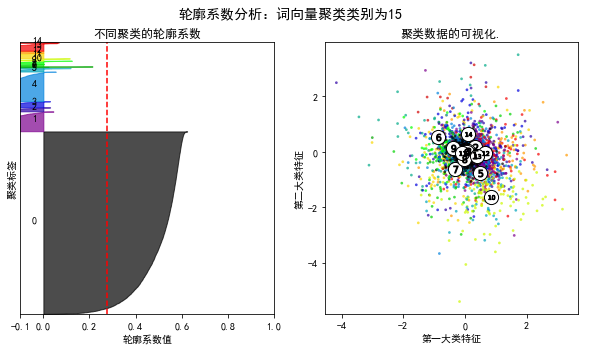

In [97]:
plot_kmeans_result(15, ted_word_vectors)

对于类别数 = 15 的平均轮廓系数为: 0.27713764


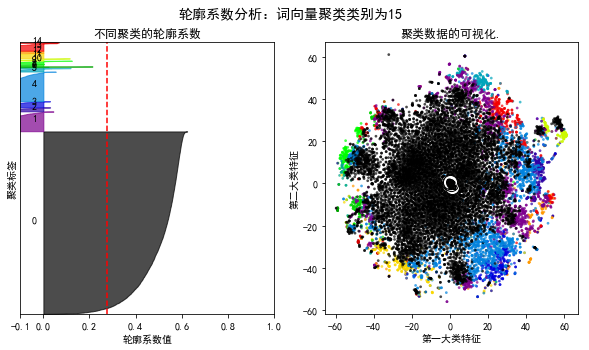

In [101]:
plot_kmeans_result(15, ted_word_vectors, True)

对于类别数 = 10 的平均轮廓系数为: 0.4484399


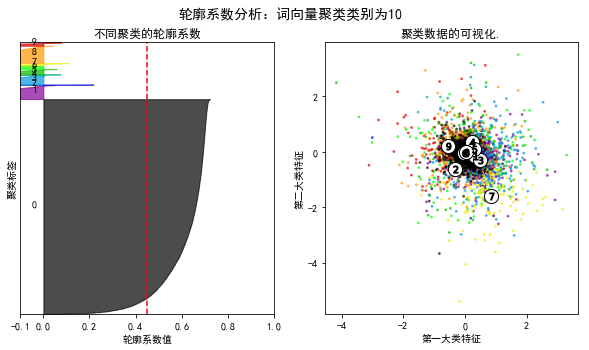

In [100]:
plot_kmeans_result(10, ted_word_vectors)

对于类别数 = 10 的平均轮廓系数为: 0.41375366


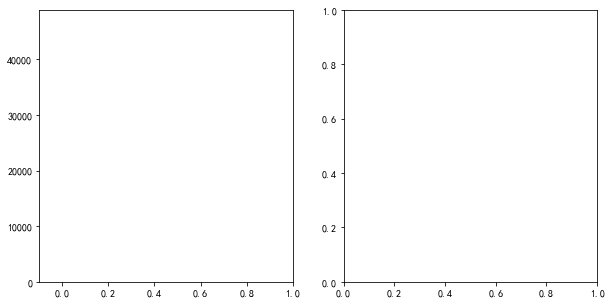

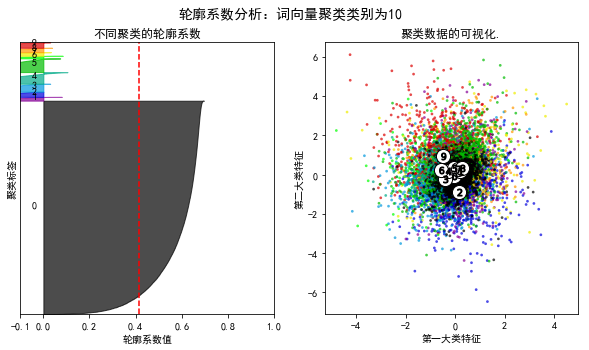

In [99]:
plot_kmeans_result(10, wiki_word_vectors)

词数量太多，可视化效果很差，我们只取前1000个词看看

对于类别数 = 10 的平均轮廓系数为: 0.04458651


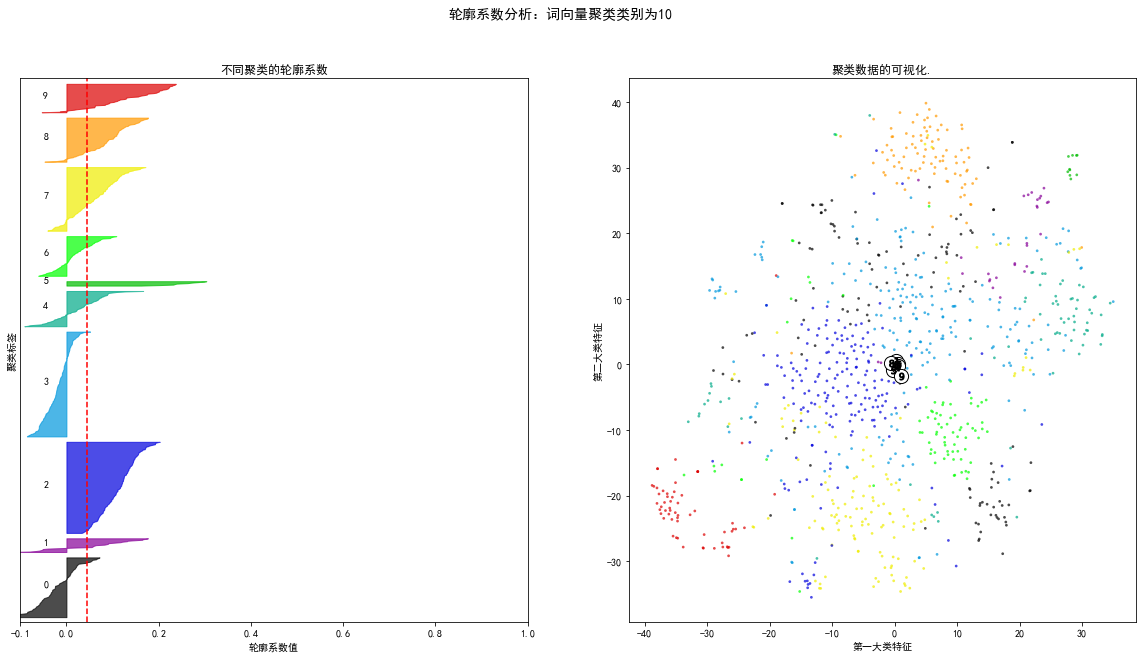

In [107]:
plot_kmeans_result(10, words_top_vec_ted, True)